<a href="https://colab.research.google.com/github/arka57/RNN/blob/main/English_Hindi_Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

In [ ]:
#Alphabet setup

In [ ]:
#English

eng_alphabets='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char='-PAD-'

english2index={pad_char:0}
for i,alphabet in enumerate(eng_alphabets):
    english2index[alphabet]=i+1

print(english2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
#Hindi
hindi_alphabets=[chr(alpha) for alpha in range(2304,2432)]
hindi_alphabets_size=len(hindi_alphabets)
hindi2index={pad_char:0}

for i,alphabet in enumerate(hindi_alphabets):
    hindi2index[alphabet]=i+1

print(hindi_alphabets)
print(hindi2index)


['ऀ', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', 'ऺ', 'ऻ', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ', 'ॐ', '॑', '॒', '॓', '॔', 'ॕ', 'ॖ', 'ॗ', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', 'ॣ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॳ', 'ॴ', 'ॵ', 'ॶ', 'ॷ', 'ॸ', 'ॹ', 'ॺ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']
{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध':

In [ ]:
#Helper method for data pre-processing

In [ ]:
import re
non_eng_letters=re.compile('[^a-zA-Z ]')


#remove all English letters

def cleanEnglish(line):
    line=line.replace('-',' ').replace(',',' ').upper()
    line=non_eng_letters.sub('',line)
    return line.split()

def cleanHindi(line):
    line=line.replace('-',' ').replace(',',' ')
    cleaned_line=''
    for char in line:
        if( char in hindi2index or char==' '):
            cleaned_line+=char
    return cleaned_line.split()

In [ ]:
cleanEnglish("Arka-57gdg jhgjh")

['ARKA', 'GDG', 'JHGJH']

In [ ]:
cleanHindi("स्टे-ट बैंक")

['स्टे', 'ट', 'बैंक']

In [ ]:
#Loading Dataset

In [ ]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET


class TransliterationDataLoader(Dataset):
    def __init__(self,filename):
        self.eng_words,self.hindi_words=self.readXMLDataset(filename,cleanEnglish,cleanHindi)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    def __len__(self):
        return len(self.eng_words)

    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]


    def readXMLDataset(self,filename,cleanEnglish,cleanHindi):
        transliteration_corpus=ET.parse(filename).getroot()
        lang1_words=[]
        lang2_words=[]

        for line in transliteration_corpus:
            wordlist1=cleanEnglish(line[0].text)
            wordlist2=cleanHindi(line[1].text)

            #skip noisy data. if no of words not same in english and hindi
            if(len(wordlist1)!=len(wordlist2)):
                print("skipping:", line[0].text,'-',line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)

            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words,lang2_words

    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))

    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]

    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1

        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0

        return eng_batch, hindi_batch



In [ ]:
train_data = TransliterationDataLoader('NEWS2012-Training-EnHi-13937.xml')


skipping: BARHARWA JUNCTION - बरहरवा
skipping: STATE BNK TR - स्टेट बैंक ऑफ त्रावणकोर
skipping: SOUTH ARLINGTON CHURCH OF CHRIST - साउथ अर्लिंग्टन
skipping: KING EDWARD VII - किंग एडवर्ड
skipping: DIBANG VALLEY - दिबंगवैली
skipping: ORDER OF VASA - ऑडर ऑफ़ द वासा
skipping: AZAMNAGAR ROAD - आज़मनगर
skipping: CAPE TOWN - केपटाउन
skipping: NEW ZEALAND - न्यूज़ीलैंड
skipping: SEA OF THE HEBRIDES - सी ऑफ हरब्रिड्‍स
skipping: RAMCOIND - राम्को इंड
skipping: KELVINGROVE ART GALLERY AND MUSEUM - केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
skipping: AUSTRALIAN NATIONAL UNIVERSITY - ऑस्ट्रेलियननेशनल यूनिवर्सिटी
skipping: JAHAN AARA - जहाँआरा
skipping: NAVABHARAT FERRO ALLOYS - नव भारत फ़ैरो अलॉय
skipping: RAMA LINGESHWARA - रामालिंगेश्वर
skipping: FAKHRUN NISA - फखरुन्निसा
skipping: REDIFF.COM INDIA LIMITED - रेडिफ़ डॉट कॉम इंडिया लिमिटेड
skipping: OMKARNATH THAKUR - ओंकार नाथ ठाकुर
skipping: OPENTV - ओपन टीवी
skipping: ENVOY COMMUNICATIONS GROUP - एन्वॉय कम्युनिकेशंस
skipping: WAR OF THE HOLY LEAGUE - वार ऑ

In [ ]:
test_data = TransliterationDataLoader('NEWS2012-Ref-EnHi-1000.xml')

In [ ]:
print(train_data[0])

('RAASAVIHAAREE', 'रासविहारी')


In [ ]:
#Basic Visualization

In [ ]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20543
Test Set Size:	 1000

Sample data from train-set:
HEALTHCARE - हेल्थकेयर
DAYS - डेज
DE - डे
DENMAN - डेनमन
RASHEED - रशीद
ARAB - अरब
WAVRE - वैवर
PAYAL - पायल
AUR - और
ASUNCION - एसुसिआन


In [ ]:
#Encoding English and Hindi Words

In [ ]:
def eng_encode(word,english2index,device='cpu'):
    rep=torch.zeros(len(word)+1,1,len(english2index)).to(device)
    for index,char in enumerate(word):
        pos=english2index[char]
        rep[index][0][pos]=1
    pad_pos=english2index[pad_char]
    rep[index+1][0][pad_pos]=1
    return rep

In [ ]:
def hindi_encode(word,hindi2index,device='cpu'):
    rep=torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
    for index,char in enumerate(word):
        pos=hindi2index[char]
        rep[index][0]=pos
    rep[index+1][0]=hindi2index[pad_char]
    return rep

In [ ]:
x=hindi_encode("दीपांशु",hindi2index)
print(x.shape)
print(x.shape[0])

torch.Size([8, 1])
8


In [ ]:
a="MY"
x=eng_encode(a,english2index)
print(a,x)

MY tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [ ]:
#Encoder_Decoder Architecture

In [ ]:
MAX_OUTPUT_CHARS=30

class Encoder_Decoder(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,verbose=False):
        super(Encoder_Decoder,self).__init__()

        self.hidden_size=hidden_size
        self.input_size=input_size
        self.output_size=output_size

        self.encoder_rnn=nn.GRU(input_size,hidden_size)
        self.decoder_rnn=nn.GRU(output_size,hidden_size)# because output of 1 decoder is input next time to decoder

        self.h2o=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=2)

        self.verbose=verbose


    def forward(self,input,max_output_chars=MAX_OUTPUT_CHARS,device='cpu',ground_truth=None):

        #encoder
        out,hidden=self.encoder_rnn(input)

        if self.verbose:
            print("Encoder input",input.shape)
            print("hidden",hidden.shape)
            print("out",out.shape)


        #decoder
        decoder_state=hidden#encoded data of encoder is passed as decoder state
        decoder_input=torch.zeros(1,1,self.output_size).to(device)
        outputs=[]

        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder input', decoder_input.shape)


        for i in range(max_output_chars):

            out,decoder_state=self.decoder_rnn(decoder_input,decoder_state)

            if self.verbose:
                print('Decoder state after each character',decoder_state.shape)
                print('Decoder intermediate output', out.shape)

            out=self.h2o(decoder_state)
            out=self.softmax(out)
            outputs.append(out.view(1,-1))


            if self.verbose:
                print('Decoder output', out.shape)
                #self.verbose = False

            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)

            decoder_input = one_hot.detach()

        return outputs


    def init_hidden(self):
        return torch.zeros(1,1,self.hidden_size)


In [ ]:
net = Encoder_Decoder(len(english2index), 256, len(hindi2index), verbose=True)

In [ ]:
def infer(net, name):
    net.eval()
    name_ohe = eng_encode(name,english2index)
    hidden = net.init_hidden()

    output=net.forward(name_ohe)
    #for i in range(name_ohe.size()[0]):
    #   output, hidden = net(name_ohe[i], hidden)

    return output

In [ ]:
out = infer(net, 'INDIA')

Encoder input torch.Size([6, 1, 27])
hidden torch.Size([1, 1, 256])
out torch.Size([6, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediat

In [ ]:
#Current output coming --this is not trained

In [ ]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi2index.keys())[list(hindi2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) ङ
torch.Size([1, 129]) ा
torch.Size([1, 129]) त
torch.Size([1, 129]) ा
torch.Size([1, 129]) त
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ


In [ ]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape, list(hindi2index.keys())[list(hindi2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) क
torch.Size([1, 129]) ि
torch.Size([1, 129]) ल
torch.Size([1, 129]) ि
torch.Size([1, 129]) न
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-


In [ ]:
#Core Training

In [ ]:
def train_batch(net,opt,criterion,batch_size,device='cpu',teacher_force=False):

    net.train().to(device)
    opt.zero_grad()
    eng_batch,hindi_batch=train_data.get_batch(batch_size)

    total_loss=0
    for i in range(batch_size):
        input=eng_encode(eng_batch[i],english2index,device)
        gt=hindi_encode(hindi_batch[i],hindi2index,device)

        outputs=net(input,gt.shape[0],device,ground_truth=gt if teacher_force else None)

        for index,output in enumerate(outputs):
            loss=criterion(output,gt[index])/batch_size
            loss.backward(retain_graph=True)
            total_loss+=loss
    opt.step()
    return total_loss/batch_size

In [ ]:
#Train Helper

def train_setup(net,lr=0.01,n_batches=100,batch_size=10,momentum=0.9,display_freq=5,device='cpu'):

    net=net.to(device)
    criterion=nn.NLLLoss(ignore_index=-1)
    opt=optim.Adam(net.parameters(),lr=lr)
    teacher_force_upto=n_batches//3

    loss_arr=np.zeros(n_batches+1)

    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)

        if i%display_freq == display_freq-1:
            clear_output(wait=True)

            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

    torch.save(net, 'model.pt')
    return loss_arr


Iteration 369 Loss 0.29539212584495544


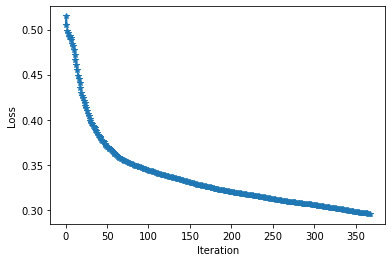

Streaming output truncated to the last 5000 lines.
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Encoder input torch.Size([6, 1, 27])
hidden torch.Size([1, 1, 256])
out torch.Size([6, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])
Decoder state after each character torch.Size([1, 1, 256])
Decoder intermediate output

KeyboardInterrupt: ignored

In [ ]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)